# Brain Tumor Detection Using Deep Learning and Transfer Learning Techniques

## Importing all the required modules

In [1]:
import torch #Deep learning operations
import torch.nn as nn #Neural network module
import torch.optim as optim #Optimization module
from torch.utils.data import DataLoader #Data loading module
from torchvision import models, transforms #Computer vision module
from torchvision.datasets import ImageFolder #Dataset structure for image classification
import matplotlib.pyplot as plt #Plotting library
import os #Operating system module

### Check if a GPU is available and set the device accordingly

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} for training.")

Using cuda for training.


### Assignment of Directories for datasets

In [3]:
train_dir = "./Training/" #Training directory
test_dir = "./Testing/" #Testing directory

###  Defining Hyperparameters

In [4]:
IMG_SIZE = 224  # Input size for ResNet models
BATCH_SIZE = 32
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

### Data Preprocessing and Augmentation

#### Data augmentation techniques are applied to the training dataset to improve the model's generalization. This includes random resized cropping, horizontal flipping, and normalization. The transformations ensure that the model learns robust features rather than overfitting to specific image patterns.

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

###  Loading the Dataset

#### The dataset is loaded using PyTorch’s ImageFolder function, which organizes images based on folder structure. The DataLoader is then used to prepare batches of data for training and testing. This step ensures efficient data handling during the training process.

In [6]:
# Load datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset = ImageFolder(test_dir, transform=test_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### ResNet-50 Overview

#### ResNet-50 is a deep convolutional neural network (CNN) with 50 layers, designed to solve the vanishing gradient problem using residual connections. These skip connections allow smooth gradient flow during backpropagation, making it highly effective for training deep networks. ResNet-50 is widely used in computer vision tasks due to its ability to extract hierarchical features from images, enabling accurate classification and object detection.

### Why ResNet-50 for Brain Tumor Detection?

#### Brain tumor images contain complex patterns and textures that require deep feature extraction, which ResNet-50 efficiently handles. Since it has been pre-trained on millions of images, it can generalize well, even when fine-tuned for medical image classification. The residual connections prevent performance degradation in deeper networks, ensuring that even subtle tumor variations are captured effectively.

### Transfer Learning with ResNet-50

#### Transfer learning allows us to leverage a pre-trained ResNet-50 model by modifying its final classification layers for brain tumor detection. The initial layers, which learn general image features, are frozen, while the later layers are fine-tuned on medical images. This significantly reduces training time and improves accuracy, as the model retains pre-learned visual representations from large datasets.

### Fine-Tuning ResNet-50 for Brain Tumor Classification

#### To adapt ResNet-50 for brain tumor detection, the last fully connected layer is replaced with a new one that has four output classes (Glioma, Meningioma, No Tumor, Pituitary). The model is then trained with a lower learning rate to avoid drastic weight updates while using data augmentation techniques to improve generalization. Optimizers like Adam or SGD are used alongside a categorical cross-entropy loss function for better classification performance.

### Advantages of Using Transfer Learning in Medical Imaging

#### Transfer learning with ResNet-50 significantly reduces computational costs and training time while maintaining high accuracy. Since medical image datasets are often limited, leveraging pre-trained models allows better generalization and feature extraction. Additionally, fine-tuning pre-trained models ensures that even a small dataset can achieve robust classification results, making it a powerful tool for brain tumor diagnosis.

### Model Selection

#### A pre-trained ResNet-50 model is loaded, leveraging transfer learning. This model has been trained on large image datasets and will be fine-tuned for brain tumor classification. Using a pre-trained model helps in achieving better accuracy with fewer training examples.

In [7]:
model = models.resnet50(pretrained=True)

c:\Users\AjayJ03\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AjayJ03\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Freezing Model Parameters for Inference or Fine-Tuning

In [8]:
for param in model.parameters():
    param.requires_grad = False

### Modifying the Final Layer of a Neural Network for Custom Classification

In [9]:
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),  # Add an intermediate layer for more learnable parameters
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout for regularization
    nn.Linear(512, NUM_CLASSES)  # Final layer for classification
)

### Enabling Gradient Updates for Specific Layers in the Model

In [10]:
for param in list(model.layer4.parameters()):
    param.requires_grad = True

### Moving the Model to the Specified Device (e.g., GPU or CPU)

In [11]:
model = model.to(device)

### Loss Function and Optimizer Setup

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

### Training Loop: Loss and Accuracy Monitoring

In [13]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=NUM_EPOCHS):
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct_preds / total_preds
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
    return train_losses, train_accuracies

### Model Evaluation: Test Loss and Accuracy Calculation

In [14]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)
    
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_preds / total_preds
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    return avg_test_loss, test_accuracy

### Training Loss and Accuracy Calculation

In [15]:
train_losses, train_accuracies = train(model, train_loader, criterion, optimizer, device)

Epoch [1/50], Loss: 0.4728, Accuracy: 0.8372
Epoch [2/50], Loss: 0.3076, Accuracy: 0.8965
Epoch [3/50], Loss: 0.2512, Accuracy: 0.9104
Epoch [4/50], Loss: 0.2294, Accuracy: 0.9210
Epoch [5/50], Loss: 0.1962, Accuracy: 0.9322
Epoch [6/50], Loss: 0.1988, Accuracy: 0.9315
Epoch [7/50], Loss: 0.1649, Accuracy: 0.9433
Epoch [8/50], Loss: 0.1554, Accuracy: 0.9435
Epoch [9/50], Loss: 0.1472, Accuracy: 0.9477
Epoch [10/50], Loss: 0.1480, Accuracy: 0.9464
Epoch [11/50], Loss: 0.1268, Accuracy: 0.9575
Epoch [12/50], Loss: 0.1348, Accuracy: 0.9568
Epoch [13/50], Loss: 0.1226, Accuracy: 0.9550
Epoch [14/50], Loss: 0.1162, Accuracy: 0.9592
Epoch [15/50], Loss: 0.1206, Accuracy: 0.9590
Epoch [16/50], Loss: 0.1172, Accuracy: 0.9575
Epoch [17/50], Loss: 0.1072, Accuracy: 0.9625
Epoch [18/50], Loss: 0.1050, Accuracy: 0.9631
Epoch [19/50], Loss: 0.1172, Accuracy: 0.9578
Epoch [20/50], Loss: 0.1040, Accuracy: 0.9617
Epoch [21/50], Loss: 0.1055, Accuracy: 0.9639
Epoch [22/50], Loss: 0.0851, Accuracy: 0.97

### Evaluating Model Performance on Test Data

In [16]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

Test Loss: 0.0442, Test Accuracy: 0.9893


### Saving the Trained ResNet-50 Model for Brain Tumor Detection

In [17]:
torch.save(model.state_dict(), "brain_tumor_resnet50_transfer_learning.pth")

### Visualization of Training Accuracy and Loss Over Epochs

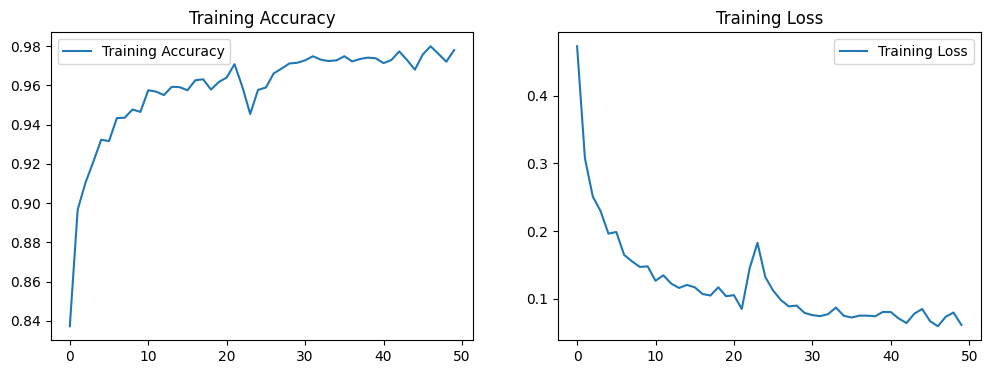

In [18]:
plt.figure(figsize=(12, 4))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.legend()
plt.title('Training Accuracy')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.legend()
plt.title('Training Loss')

plt.show()